# Virtual data set (VDS) reference file for ECCO_L4_OBP_05DEG_DAILY_V4R4B using Virtualizarr


In [1]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [2]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [3]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [4]:
# Locate CCMP file information / metadata:
shortname = "ECCO_L4_OBP_05DEG_DAILY_V4R4B"
granule_info = earthaccess.search_data(
    short_name=shortname,
    )

In [6]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print("Number of granules found =", len(data_s3links))
print("First few granules:")
data_s3links[0:5]

Number of granules found = 9497
First few granules:


['s3://podaac-ops-cumulus-protected/ECCO_L4_OBP_05DEG_DAILY_V4R4B/OCEAN_BOTTOM_PRESSURE_day_mean_1992-01-01_ECCO_V4r4b_latlon_0p50deg.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_OBP_05DEG_DAILY_V4R4B/OCEAN_BOTTOM_PRESSURE_day_mean_1992-01-02_ECCO_V4r4b_latlon_0p50deg.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_OBP_05DEG_DAILY_V4R4B/OCEAN_BOTTOM_PRESSURE_day_mean_1992-01-03_ECCO_V4r4b_latlon_0p50deg.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_OBP_05DEG_DAILY_V4R4B/OCEAN_BOTTOM_PRESSURE_day_mean_1992-01-04_ECCO_V4r4b_latlon_0p50deg.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_OBP_05DEG_DAILY_V4R4B/OCEAN_BOTTOM_PRESSURE_day_mean_1992-01-05_ECCO_V4r4b_latlon_0p50deg.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [7]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["time", "latitude", "longitude", "nv"]

In [8]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [9]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [10]:
# Start up cluster and print some information about it:
client = Client(n_workers=30, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

/opt/coiled/env/lib/python3.13/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38467 instead
  warnings.warn(


LocalCluster(827a8f93, 'tcp://127.0.0.1:46327', workers=30, threads=30, memory=122.25 GiB)
View any work being done on the cluster here https://cluster-bvltc.dask.host/jupyter/proxy/38467/status


In [11]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 41.7 s, sys: 6.19 s, total: 47.9 s
Wall time: 1min 36s


In [12]:
len(virtual_ds_list)

9497

## 3. Generate combined reference file

In [13]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='time', coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 5.46 s, sys: 223 ms, total: 5.68 s
Wall time: 5.44 s


In [14]:
# Save in JSON or PARQUET format:
fname_combined_json = shortname + "_virtual_s3" + ".json"
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')

## 4. Test combined reference files

In [15]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

### 4.1 JSON reference file

In [16]:
%%time
data = opends_withref(fname_combined_json, fs)
data

CPU times: user 307 ms, sys: 39.4 ms, total: 346 ms
Wall time: 451 ms


<xarray.Dataset> Size: 20GB
Dimensions:         (time: 9497, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    OBP             (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    OBPGMAP         (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    source:                       The ECCO V4r4b state estimate was produced ...
    standard_name_vocabulary:     NetCDF Climate and Forecast (CF) Metadata C...
    summary:                      This product (Version 4, Release 4b) is the...
    time_coverage_duration:       P1D
    time_coverage_resolution:     P1D
    title:                        ECCO Ocean Bottom Pressure - Daily Mean 0.5...

In [17]:
lat_range = (0, 45)
lon_range = (-130, -100)
time_range = (np.datetime64("2010-01-01"), np.datetime64("2013-01-02"))
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=slice(*time_range))
data_subset

<xarray.Dataset> Size: 47MB
Dimensions:         (time: 1097, latitude: 90, longitude: 60, nv: 2)
Coordinates:
  * latitude        (latitude) float32 360B 0.25 0.75 1.25 ... 43.75 44.25 44.75
    latitude_bnds   (latitude, nv) float32 720B dask.array<chunksize=(90, 2), meta=np.ndarray>
  * longitude       (longitude) float32 240B -129.8 -129.2 ... -100.8 -100.2
    longitude_bnds  (longitude, nv) float32 480B dask.array<chunksize=(60, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 9kB 2010-01-01T12:00:00 ... 2013-01...
    time_bnds       (time, nv) datetime64[ns] 18kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    OBP             (time, latitude, longitude) float32 24MB dask.array<chunksize=(1, 90, 60), meta=np.ndarray>
    OBPGMAP         (time, latitude, longitude) float32 24MB dask.array<chunksize=(1, 90, 60), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    source:                       The ECCO V4r4b state estimate was produced ...
    standard_name_vocabulary:     NetCDF Climate and Forecast (CF) Metadata C...
    summary:                      This product (Version 4, Release 4b) is the...
    time_coverage_duration:       P1D
    time_coverage_resolution:     P1D
    title:                        ECCO Ocean Bottom Pressure - Daily Mean 0.5...

In [20]:
ws_mean_map = data_subset["OBPGMAP"].mean(dim="time").compute()

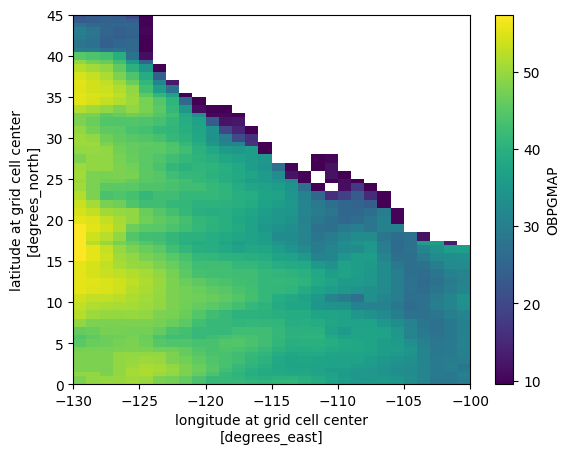

In [21]:
ws_mean_map.plot()